# Natural Language Processing Project
## NLP Course @ Politecnico di Milano 2022/2023 - Prof. Mark Carman
### Topic 4: Autextification

### Group: Residual Sum of Students
- Raul Singh
- Davide Rigamonti
- Francesco Tosini
- Enrico Zuccolotto

## Introduction

The dataset consists of *short text passages* that have either been written by a *human* or have been generated automatically by a *language model*, more information can be found on the [official site](https://sites.google.com/view/autextification).

The original task will take place as part of [IberLEF 2023](http://sepln2023.sepln.org/en/iberlef-en/), the 5th Workshop on Iberian Languages Evaluation Forum at the SEPLN 2023 Conference, which will be held in Jaén, Spain on the 26th of September, 2023.

Given the scope of the original challenge we can observe that the dataset contains two separate set of samples, one in **English** and the other in **Spanish**; our main focus will be on the **English** dataset.

We will treat the two tasks **separately** as the two respective goals are different; although some similarities can be traced between the two, most of the considered approaches will be symmetrical and net homogeneous results.

Each task will be presented with a brief **data exploration** section, then we will proceed to utilize models and approaches that we have seen in the course (with the introduction of some novelties) starting from the most basic techniques based on the **Bag of Words representation** to then transition towards approaches that utilize **Word Embeddings** to then reach the *state-of-the-art* **Transformer** models.

## Preliminary initialization

This section contains all the library imports, helper function initialization calls and global variable definitions.

### Imports

#### Utilized libraries
The following dependencies are needed to run the notebook:
```
pip install scikit-learn~=1.2.2
pip install torch~=2.0.0
pip install matplotlib~=3.7.1
pip install plotly~=5.14.1
pip install nltk~=3.8.1
pip install spacy~=3.5.1
pip install textstat~=0.7.3
pip install numpy~=1.24.2
pip install pandas~=2.0.0
pip install python-terrier~=0.9.2
pip install scipy~=1.9.3
pip install gensim~=4.3.1
pip install lexicalrichness~=0.5.0
pip install sentence-transformers~=2.2.2
pip install transformers~=4.28.1
pip install datasets~=2.12.0
pip install evaluate~=0.4.0
```

#### Python standard library

In [11]:
import re
import os
import sys
import abc
import random
import string

import copy as cp
import array as arr

from collections import Counter

#### Scikit-learn

In [56]:
from sklearn import metrics

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#### Pytorch

In [2]:
import torch

import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

#### Plotting

In [3]:
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go

from plotly.subplots import make_subplots

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Various

In [4]:
import nltk
import spacy
import textstat

import evaluate as hf_ev
import numpy as np
import pandas as pd
# import pyterrier as pt
import scipy.sparse as sps

import gensim.downloader as api

from spacy import displacy
from nltk.corpus import stopwords
from pandas.core.common import flatten
from datasets import Dataset, DatasetDict
from gensim.models.word2vec import Word2Vec
from lexicalrichness import LexicalRichness
from sentence_transformers import SentenceTransformer, util
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification

### Helper functions

#### Pytorch models

In [5]:
history_metrics = {
    "epoch": {},
    "loss": {"order": -1},
    "val_loss": {"order": -1},
    "acc": {"order": +1},
    "val_acc": {"order": +1},
}

In [6]:
class StopNNLoop(BaseException):
    pass

def build_history_string(history_point):
    epoch = history_point["epoch"]
    metrics_string = " ".join(
        [f"{k}: {history_point[k]:.7f}" for k in history_point if not k == "epoch"]
    )
    return f"Epoch {epoch} -- " + metrics_string


def compare_equal_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(
        model_1.state_dict().items(), model_2.state_dict().items()
    ):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if key_item_1[0] == key_item_2[0]:
                print("Mismtach found at", key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        return True
    return False


# Returns true if a is "better" than b following the metric
def compare_metric(metric, a, b, delta=0):
    if a == b:
        return False
    if history_metrics[metric]["order"] == +1:
        return a > b + delta
    return a < b - delta


# Initializes lowest possible value given a metric
def init_lowest(metric):
    return -np.inf if history_metrics[metric]["order"] == +1 else np.inf


def init_gpu(gpu="cuda:0"):
    return torch.device(gpu if torch.cuda.is_available() else "cpu")

In [7]:
class Data(dt.Dataset):
    def __init__(self, x, y, x_type=np.int32, y_type=torch.float):
        x_coo = x.tocoo()
        self.x = torch.sparse.FloatTensor(
            torch.LongTensor([x_coo.row, x_coo.col]),
            torch.FloatTensor(x_coo.data.astype(x_type)),
            x_coo.shape,
        )
        self.y = torch.tensor(y, dtype=y_type)
        self.shape = self.x.shape

    def __getitem__(self, index):
        return self.x[index].to_dense(), self.y[index]

    def __len__(self):
        return self.shape[0]

In [8]:
class Classifier(nn.Module):
    def __init__(self, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__()
        self.device = device
        self.is_binary = binary_classifier
        self.verbose = verbose
        self.is_compiled = False
        self.history = []

    def forward(self, x):
        return x

    def compile(self, loss, optimizer, binary_threshold=0.5):
        self.loss = loss
        self.optimizer = optimizer
        self.binary_threshold = binary_threshold
        self.to(self.device)
        self.is_compiled = True

    def parse_logits(self, outputs):
        if self.is_binary:
            predicted = (outputs > self.binary_threshold).float()
        else:
            _, predicted = torch.max(outputs.data, 1)
        return predicted

    def train_loop(self, data, epochs, data_val=None, callbacks=[]):
        try:
            tot = len(data.dataset)
            # Iterate over all epochs
            for epoch in range(epochs):
                running_loss = 0.0
                correct = 0
                history_point = {}
                # Iterate over each dataset batch
                for i, datum in enumerate(data):
                    # Decompose batch in x and y
                    inputs, labels = datum
                    # Set gradients to zero
                    self.optimizer.zero_grad()
                    # Forward pass
                    outputs = self(inputs)
                    predictions = self.parse_logits(outputs)
                    current_loss = self.loss(outputs, labels)
                    # Backpropagation
                    current_loss.backward()
                    # Optimization
                    self.optimizer.step()
                    # Update metrics
                    running_loss += current_loss.item()
                    correct += (predictions == labels).float().sum()

                # Compute training metrics
                history_point["epoch"] = epoch + 1
                history_point["loss"] = running_loss / tot
                history_point["acc"] = correct / tot

                # Compute and save eventual validation metrics
                if data_val:
                    _, val_metrics = self.test_loop(data_val)
                    history_point["val_loss"] = val_metrics["loss"]
                    history_point["val_acc"] = val_metrics["acc"]

                # Save epoch in history
                self.history.append(history_point)

                # Perform callbacks
                for callback in callbacks:
                    callback.call(self, history_point)

                # Print epoch summary
                if self.verbose:
                    print(build_history_string(history_point))

        except StopNNLoop as s:  # noqa
            pass

    def test_loop(self, data):
        all_predictions = np.array([])
        tot = len(data.dataset)
        loss = 0.0
        correct = 0
        metrics = {}
        # Prevent model update
        with torch.no_grad():
            # Iterate over each dataset batch
            for datum in data:
                # Decompose batch in x and y
                inputs, labels = datum
                # Forward pass
                outputs = self(inputs)
                predictions = self.parse_logits(outputs)
                current_loss = self.loss(outputs, labels)
                # Update metrics
                loss += current_loss.item()
                correct += (predictions == labels).float().sum()
                # Append predictions
                all_predictions = np.append(all_predictions, predictions)

        # Compute metrics
        metrics["acc"] = correct / tot
        metrics["loss"] = loss / tot

        return all_predictions.flatten(), metrics

In [12]:
class Callback(metaclass=abc.ABCMeta):
    def __init__(self, inputs):
        if not isinstance(inputs, list):
            raise TypeError("Parameter 'inputs' must be a list")
        if not all(x in history_metrics for x in inputs):
            raise ValueError(
                "Unknown input value, not present in Callback.callback_inputs"
            )
        self.inputs = inputs

    def inputs_check(self, inputs):
        if not all(x in inputs for x in self.inputs):
            raise ValueError(
                f"Requested inputs not provided: {[i for i in inputs if i not in self.inputs]}"
            )

    @abc.abstractmethod
    def call(self, model, inputs):
        self.inputs_check(inputs)
        pass

class EarlyStopping(Callback):
    def __init__(
        self,
        metric="loss",
        patience=10,
        baseline=None,
        delta=0,
        restore_best=True,
        verbose=True,
    ):
        super().__init__([metric])
        self.metric = metric
        self.patience = patience
        self.baseline = baseline
        self.delta = delta
        self.restore_best = restore_best
        self.verbose = verbose
        self.best_epoch = 0
        self.counter = 0
        self.saved_params = {}
        self.last_best = init_lowest(self.metric)

    def call(self, model, inputs):
        super().call(model, inputs)
        if self.early_stop(model, inputs):
            raise StopNNLoop()

    def early_stop(self, model, inputs):
        metric = inputs[self.metric]
        # Check if new metric is better than the current best
        if compare_metric(self.metric, metric, self.last_best):
            # Reset counter and update best value
            self.last_best = metric
            self.counter = 0
            self.best_epoch = inputs["epoch"]
            # Update model checkpoint
            if compare_metric(self.metric, metric, self.baseline):
                self.saved_params = cp.deepcopy(model.state_dict())
        # Check if new metric is worse than the current best
        elif compare_metric(self.metric, self.last_best, metric, self.delta):
            # Increment counter
            self.counter += 1
            # Check if counter exceeds patience, if so interrupt training
            if self.counter >= self.patience:
                # Restore best model checkpoint if possible and wanted
                if not self.restore_best:
                    return True
                if self.saved_params:
                    model.load_state_dict(self.saved_params)
                if self.verbose:
                    if self.saved_params:
                        print(f"Model restored successfully @ epoch {self.best_epoch}")
                    else:
                        print(f"Couldn't restore model @ epoch {self.best_epoch}")
                return True
        return False


class AdaptLR(Callback):
    def __init__(self, metric="loss", patience=5, factor=0.1, delta=0, verbose=True):
        super().__init__([metric])
        self.metric = metric
        self.patience = patience
        self.factor = factor
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.last_best = init_lowest(self.metric)

    def call(self, model, inputs):
        super().call(model, inputs)
        if self.adaptlr(inputs):
            # Adapt learning rate
            out = []
            for g in model.optimizer.param_groups:
                g["lr"] *= self.factor
                out = g["lr"]
            if self.verbose:
                print(f"Reducing lr to {out:.4f}")

    def adaptlr(self, inputs):
        metric = inputs[self.metric]
        # Check if new metric is better than the current best
        if compare_metric(self.metric, metric, self.last_best):
            # Reset counter and update best value
            self.last_best = metric
            self.counter = 0
        # Check if new metric is worse than the current best
        elif compare_metric(self.metric, self.last_best, metric, self.delta):
            # Increment counter
            self.counter += 1
            # Check if counter exceeds patience, if so interrupt training
            if self.counter >= self.patience:
                self.counter = 0
                return True
        return False

#### Generic utility

In [13]:
def split(x, y, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size + val_size, stratify=y, random_state=seed
    )
    x_val, y_val = None, None
    if val_size > 0:
        x_test, x_val, y_test, y_val = train_test_split(
            x_test,
            y_test,
            test_size=val_size / (test_size + val_size),
            stratify=y_test,
            random_state=seed,
        )
    return x_train, x_val, x_test, y_train, y_val, y_test

def compact_split(dataset, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    train, test = train_test_split(
        dataset, test_size=test_size + val_size, random_state=seed
    )
    val = None
    if val_size > 0:
        val, test = train_test_split(
            test,
            test_size=test_size / (test_size + val_size),
            random_state=seed,
        )
    return train, val, test

def evaluate(y_true, y_pred, labels=None):
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_display.plot()
    plt.show()

def save_scikit_model(path, model, name):
    Path(path).mkdir(parents=True, exist_ok=True)
    dump(model, path + "/" + name)

def load_scikit_model(path, name):
    model_path = path + "/" + name
    if exists(model_path) and isfile(model_path):
        try:
            return load(model_path)
        except:
            pass
    return None

### Variable definitions

In [14]:
seed = 42
np.random.seed(seed)
random.seed(seed)

#### Library initialization calls

In [15]:
%%capture
# Load spacy pipeline model
!{sys.executable} -m spacy download en_core_web_sm

## Task 1

The challange is subdivided in two main tasks, the first is a **Binary Classification** task that aims at identifying if a text passage was *written by a human* or if it was *generated from a langauge model*.

### Data Exploration

In [16]:
# TODO

#### Indexing


In [50]:
df = pd.read_csv("/kaggle/input/subtask1-en/train.tsv",sep="\t",header=0)
pd.set_option('display.max_colwidth', 150)

df.head(5)

,id,text,label
0,12322,you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe,generated
1,1682,"The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessar...",generated
2,22592,"I have not been tweeting a lot lately, but I did in November, and it was a really good month. I also",generated
3,17390,I pass my exam and really thankgod for that but idk where will I go for shsmy result is ah,human
4,30453,"The template will have 3 parts: a mustache shape, a bow tie shape, and a skinny rectangle. The mustache shape will eventually make the bow loops. ...",human


Let's check the dataset size

In [51]:
print(f"No. of sentences: {len(df)}")

No. of sentences: 33845


Let's print some sentences and try to understand something about this dataset

In [52]:
for i in range(20):
    print(df['text'][i])
    print("\n")

you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe


The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessary or appropriate. 2. The Commission may request any relevant information from the Member States, the Council, the European Parliament, international organizations, bodies or specialized agencies. 3. The Commission shall ensure adequate access by the competent national authorities for the purpose of implementing this Regulation. 4. The Commission shall give special attention to the social dimension of the programme. 5. The


I have not been tweeting a lot lately, but I did in November, and it was a really good month. I also


I pass my exam and really thankgod for that but idk where will I go for shsmy result is ah


The template will have 3 parts: a mustache shape, a bow tie shape, and a skinny rectangle. The mustache shape will eventually m

This data seems to be talking about news and reviews about a vastity of topics.Some legal articles,some tweets and something like wikipedia

Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents.

In the following cell, we index the dataframe's documents. 

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
df['docno']=str(df["id"])
index_ref = indexer.index(df["text"], df["docno"])
index_ref.toString()

In [ ]:
index = pt.IndexFactory.of(index_ref)

Some statistics about our data

In [ ]:
print(index.getCollectionStatistics().toString())

Now we will ask some queries 

In [ ]:
query = "potato"
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query)
br = pt.BatchRetrieve(index, wmodel="TF_IDF")
queries=br.search(query)
queries.head()

#### Clustering

In [57]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [58]:
documents=np.array(df['text'])
labels = np.array(df['label'])

We have obtained a relative small vocubalary only 11k words

In [59]:
vectorizer.fit(documents)
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 11557


In [60]:
vector_documents = vectorizer.transform(documents)

we try to see if clustering this data can lead to actual classes

In [62]:
for i in range(1,200):
    if (labels[i] == labels[0]):
      print('Similarity:', vector_documents[0].multiply(vector_documents[i]).sum())

Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.02198864376572125
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.023254981000023926
Similarity: 0.0
Similarity: 0.0
Similarity: 0.05465414018686425
Similarity: 0.0
Similarity: 0.0
Similarity: 0.04271130589763102
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similar

We have used the most basic clustering algorithm to see if there is any chance

In [63]:
k = len(set(labels))
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 67084.47462234153.
Iteration 1, inertia 33392.0984793211.
Iteration 2, inertia 33308.75747079339.
Iteration 3, inertia 33186.99125674895.
Iteration 4, inertia 32846.08480709025.
Iteration 5, inertia 32738.42857947717.
Iteration 6, inertia 32701.090729042997.
Iteration 7, inertia 32684.420324121966.
Iteration 8, inertia 32676.32200954747.
Iteration 9, inertia 32672.259157363653.
Iteration 10, inertia 32670.244503493097.
Iteration 11, inertia 32669.285943947605.
Iteration 12, inertia 32668.707969005667.
Iteration 13, inertia 32668.341695537732.
Iteration 14, inertia 32668.161644015858.
Iteration 15, inertia 32668.118911826932.
Iteration 16, inertia 32668.111221099236.
Iteration 17, inertia 32668.098798816576.
Iteration 18, inertia 32668.07836230531.
Iteration 19, inertia 32668.063546554473.
Iteration 20, inertia 32668.054540119665.
Iteration 21, inertia 32668.04304429433.
Iteration 22, inertia 32668.036725095437.
Iteration 23, inertia 32668.03

KMeans(max_iter=100, n_clusters=2, n_init=2, random_state=2307, verbose=True)

Evaluation of our clustering

In [64]:
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(labels, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(labels, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(labels, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(labels, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 32668.03230384869
Silhouette coefficient: 0.011687671020057766
Extrinsic evaluation measures:
Homogeneity: 0.06476441677697967
Completeness: 0.12404977572786542
V-measure: 0.08509965558997028
Adjusted Rand-Index: 0.03102009598058132


As we can see from this metrics and as we expect it perfomed terribly. We can say that the content of the sentences is not related to the label.

### Bag of Words-based models and other approaches

In [16]:
# TODO

### Text embedding approaches

In [17]:
df = pd.read_csv("/kaggle/input/subtask1-en/train.tsv",sep="\t",header=0)
pd.set_option('display.max_colwidth', 150)
labels = ["generated", "human"]
df = df.drop("id", axis=1)
df.head()

,text,label
0,you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe,generated
1,"The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessar...",generated
2,"I have not been tweeting a lot lately, but I did in November, and it was a really good month. I also",generated
3,I pass my exam and really thankgod for that but idk where will I go for shsmy result is ah,human
4,"The template will have 3 parts: a mustache shape, a bow tie shape, and a skinny rectangle. The mustache shape will eventually make the bow loops. ...",human


We shuffle the dataset and we exchange the categorical values with binary one.

In [20]:
df.sample(frac=1)
df['label'] = df['label'].replace({'generated':0, 'human':1})


#### Helper functions for evaluating word embedding models
Some useful functions to evaluate our models and embeddings.

In [21]:
regex = '[' + string.punctuation + ']'

def vectorize(docs, embedding_model, useSum=False,dim=50,built=True):
    vectors = np.zeros((len(docs),dim))
    for i in range(len(docs)):
        tokens = re.sub(regex, '', docs[i]).split()
        if built:
            embeddings = [embedding_model.wv[token] for token in tokens if token in embedding_model.wv.key_to_index]
        else:
            embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        
        if (len(embeddings) > 0):
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [22]:
def prep_dataset(word_embeds,dim=50,tr=False):
    if isinstance(word_embeds, str):
        if tr:
            embd = SentenceTransformer(word_embeds)
            x_train = embd.encode(np.array(df.text), convert_to_tensor=False)
        else:
            model = api.load(word_embeds)
            x_train = vectorize(np.array(df['text']),model,True,dim,False)
    else:
        model= Word2Vec(word_embeds, vector_size=dim, min_count=5, window=10)
        x_train = vectorize(np.array(df['text']),model,True,dim,True)
        
    y_train= np.array(df['label'])
    x_train, x_val, x_test, y_train, y_val, y_test = split(x_train, y_train, test_size=0.2, val_size=0.0)
    return x_train, x_test, y_train, y_test

In [23]:
def setup_models(usecached = False):   
    models = []
    

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr_param = [
        {
        "solver": ["liblinear"], 
        "penalty": ["l1", "l2"],
         "C":[0.01, 0.1, 1, 10]
     },{
         "solver": ("lbfgs", "sag", "saga"), 
         "penalty": ["l2"],
        "C":[0.01, 0.1, 1]
    }
    ]
    lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
    models.append({
        "name": "Linear Regression",
        "model": lr_clf,
        "subsample": 0.7,
        "usecached": usecached,
    })

    # SVC
    svc = SVC()
    svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
    svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
    models.append({
        "name": "SVC",
        "model": svc_clf,
        "subsample": 0.7,
        "usecached": usecached,
    })

    # Decision Tree
    dtree = DecisionTreeClassifier()
    dtree_param = {
        "criterion": ["gini", "entropy"], 
        # "min_samples_split": [2, 4, 8],
        # "min_samples_leaf": [1, 2, 4],
        "max_features": [None, "sqrt", "log2"],
    }
    dtree_clf =  GridSearchCV(dtree, dtree_param, cv=5, scoring="f1_micro", verbose=1)
    models.append({
        "name": "Decision Tree",
        "model": dtree_clf,
        "usecached": usecached,
    })

    # Random Forest
    rf = RandomForestClassifier()
    rf_param = {
        # "n_estimators": [50, 100, 200, 400],
        # "max_depth": [None, 5, 10],
        "criterion": ["entropy"],
        # "min_samples_split": [2, 4, 8],
        # "min_samples_leaf": [1, 2, 4],
        # "max_features": [None, "sqrt", "log2"],
        # "oob_score": [True, False]
    }
    rf_clf =  GridSearchCV(rf, rf_param, cv=5, scoring="f1_micro", verbose=1)
    models.append({
        "name": "Random Forest",
        "model": rf_clf,
        "subsample": 0.6,
        "usecached": usecached,
    })

    # Extra Trees
    et = ExtraTreesClassifier()
    et_param = {
        # "n_estimators": [50, 100, 200, 400],
        # "max_depth": [None, 5, 10],
        "criterion": ["entropy"],
        # "min_samples_split": [2, 4, 8],
        # "min_samples_leaf": [1, 2, 4],
        # "max_features": [None, "sqrt", "log2"],
        # "oob_score": [True, False]
    }
    et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
    models.append({
        "name": "Extra Trees",
        "model": et_clf,
        "subsample": 0.6,
        "usecached": usecached,
    })
    return models

In [24]:
def train_models(models,x_train,y_train):    
    for model in models:
        print(f"Training {model['name']}")

        x_train_, y_train_ = x_train, y_train
        if "subsample" in model.keys():
            x_train_, _, y_train_, _ = train_test_split(
                x_train, 
                y_train, 
                test_size=model["subsample"], 
                stratify=y_train
            )

        model["model"].fit(x_train_, y_train_)

        print("Found best model")
        model["best"] = model["model"].best_estimator_
        model["best"].fit(x_train, y_train)
        print("Trained best model")

In [25]:
def evaluate_models(models,x_test,y_test):
    for model in models:
        print(f"{model['name']}")
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
        y_pred = model['best'].predict(x_test)
        evaluate(y_test, y_pred, labels=labels)

#### Building our word embedding

In [25]:
docs = [re.sub('\n', ' ', doc) for doc in df.text]
sentences = [re.split('[?!.]\s', doc) for doc in docs]
sentences = list(flatten(sentences))
sentences[:3]

['you need to stop the engine and wait until it stops',
 'This is how I would do it: // Check if its safe',
 'The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessary or appropriate']

In [26]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]

Training Linear Regression

Fitting 5 folds for each of 17 candidates, totalling 85 fits

Found best model

Trained best model

Training SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Found best model

Trained best model

Training Decision Tree

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Found best model

Trained best model

Training Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Training Extra Trees

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Linear Regression

Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

Best CV score: 0.6931798408488064

              precision    recall  f1-score   support



           0       0.70      0.69      0.69      3360

           1       0.70      0.71      0.70      3409



    accuracy                           0.70      6769

   macro avg       0.70      0.70      0.70   

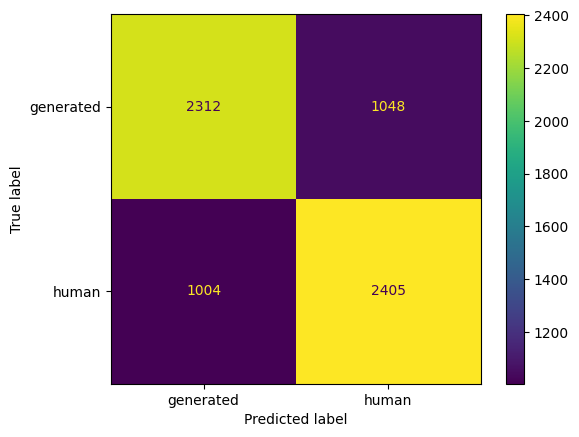

SVC

Best parameters: {'C': 10, 'kernel': 'rbf'}

Best CV score: 0.7554805608184918

              precision    recall  f1-score   support



           0       0.78      0.77      0.78      3360

           1       0.78      0.79      0.78      3409



    accuracy                           0.78      6769

   macro avg       0.78      0.78      0.78      6769

weighted avg       0.78      0.78      0.78      6769




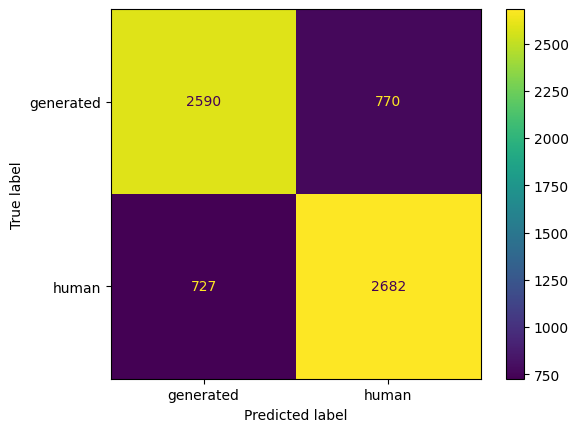

Decision Tree

Best parameters: {'criterion': 'entropy', 'max_features': None}

Best CV score: 0.66793454911476

              precision    recall  f1-score   support



           0       0.67      0.66      0.66      3360

           1       0.67      0.67      0.67      3409



    accuracy                           0.67      6769

   macro avg       0.67      0.67      0.67      6769

weighted avg       0.67      0.67      0.67      6769




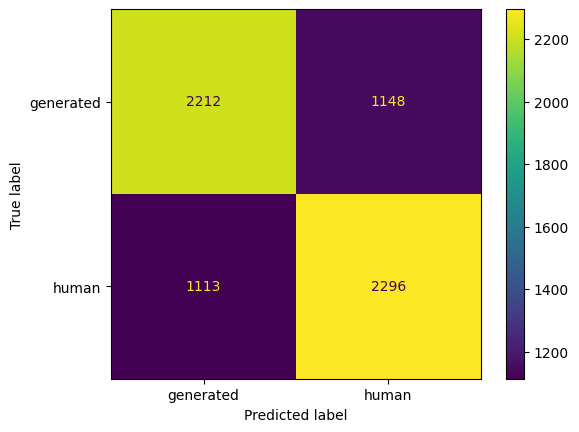

Random Forest

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7610341643582641

              precision    recall  f1-score   support



           0       0.75      0.76      0.76      3360

           1       0.76      0.75      0.76      3409



    accuracy                           0.76      6769

   macro avg       0.76      0.76      0.76      6769

weighted avg       0.76      0.76      0.76      6769




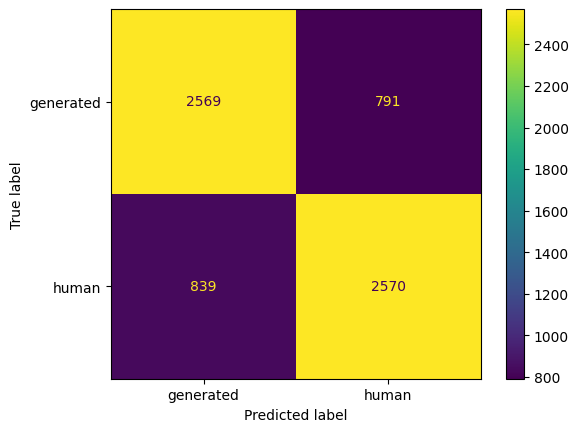

Extra Trees

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7549399815327793

              precision    recall  f1-score   support



           0       0.76      0.77      0.76      3360

           1       0.77      0.76      0.76      3409



    accuracy                           0.76      6769

   macro avg       0.76      0.76      0.76      6769

weighted avg       0.76      0.76      0.76      6769




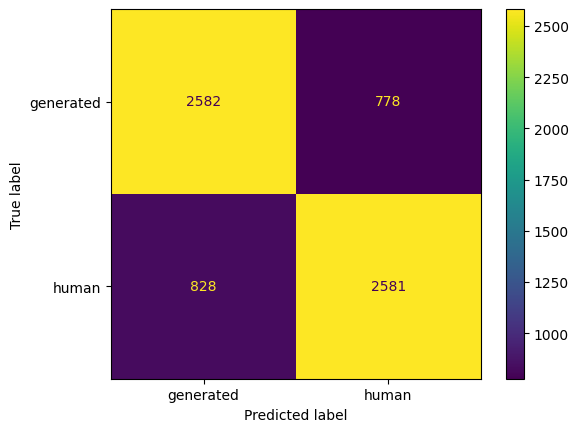

Training Linear Regression

Fitting 5 folds for each of 17 candidates, totalling 85 fits

Found best model

Trained best model

Training SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Found best model

Trained best model

Training Decision Tree

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Found best model

Trained best model

Training Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Training Extra Trees

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Linear Regression

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Best CV score: 0.7143589238347859

              precision    recall  f1-score   support



           0       0.71      0.71      0.71      3360

           1       0.71      0.72      0.72      3409



    accuracy                           0.71      6769

   macro avg       0.71      0.71      0.71    

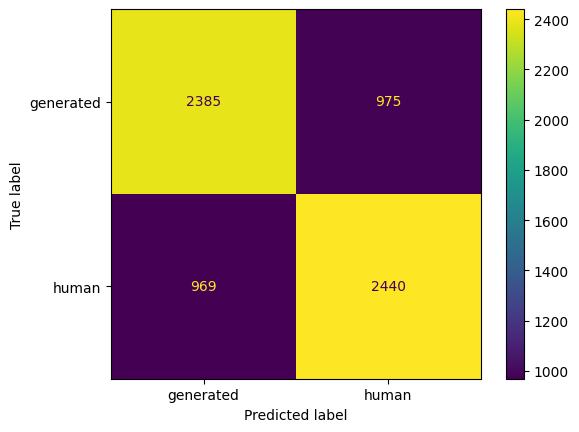

SVC

Best parameters: {'C': 10, 'kernel': 'rbf'}

Best CV score: 0.7753013262599471

              precision    recall  f1-score   support



           0       0.80      0.79      0.80      3360

           1       0.80      0.80      0.80      3409



    accuracy                           0.80      6769

   macro avg       0.80      0.80      0.80      6769

weighted avg       0.80      0.80      0.80      6769




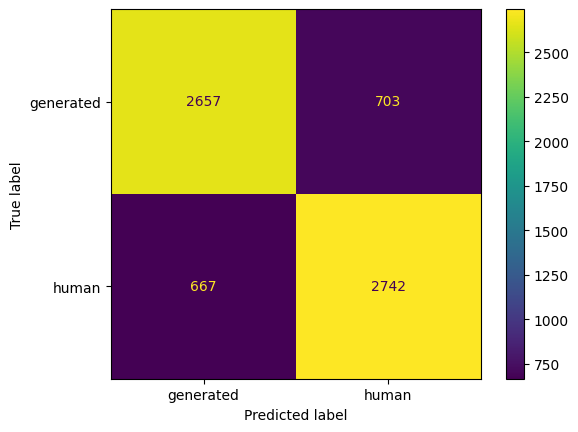

Decision Tree

Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt'}

Best CV score: 0.6685253910645385

              precision    recall  f1-score   support



           0       0.66      0.65      0.66      3360

           1       0.66      0.66      0.66      3409



    accuracy                           0.66      6769

   macro avg       0.66      0.66      0.66      6769

weighted avg       0.66      0.66      0.66      6769




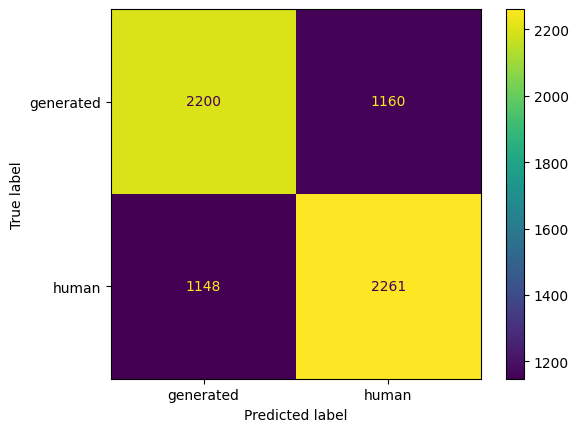

Random Forest

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7533702677746998

              precision    recall  f1-score   support



           0       0.76      0.76      0.76      3360

           1       0.77      0.77      0.77      3409



    accuracy                           0.76      6769

   macro avg       0.76      0.76      0.76      6769

weighted avg       0.76      0.76      0.76      6769




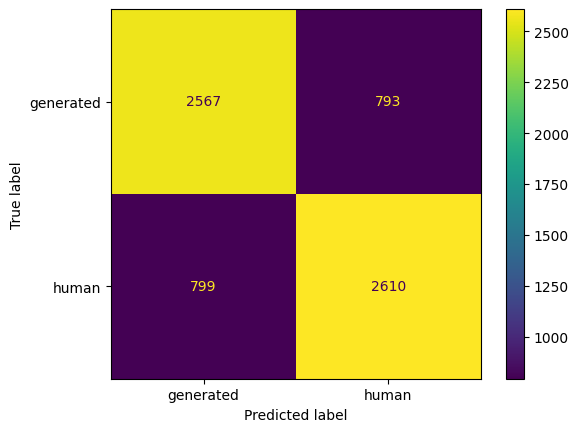

Extra Trees

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7546629732225301

              precision    recall  f1-score   support



           0       0.76      0.77      0.76      3360

           1       0.77      0.76      0.77      3409



    accuracy                           0.77      6769

   macro avg       0.77      0.77      0.77      6769

weighted avg       0.77      0.77      0.77      6769




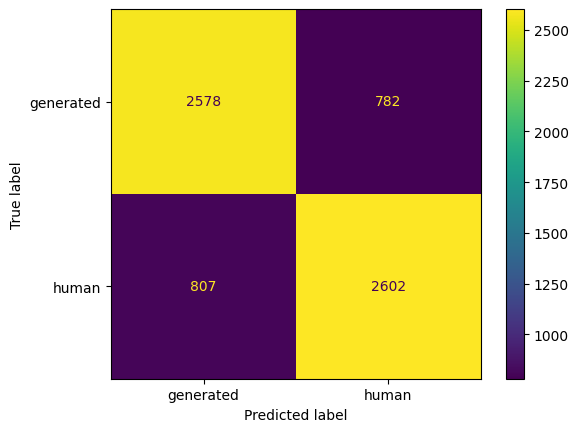

Training Linear Regression

Fitting 5 folds for each of 17 candidates, totalling 85 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reac

Found best model

Trained best model

Training SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Found best model

Trained best model

Training Decision Tree

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Found best model

Trained best model

Training Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Training Extra Trees

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Linear Regression

Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best CV score: 0.7154641151951496

              precision    recall  f1-score   support



           0       0.73      0.72      0.72      3360

           1       0.73      0.74      0.73      3409



    accuracy                           0.73      6769

   macro avg       0.73      0.73      0.73      6769

weighted avg       0.73      0.73      0.73      6769




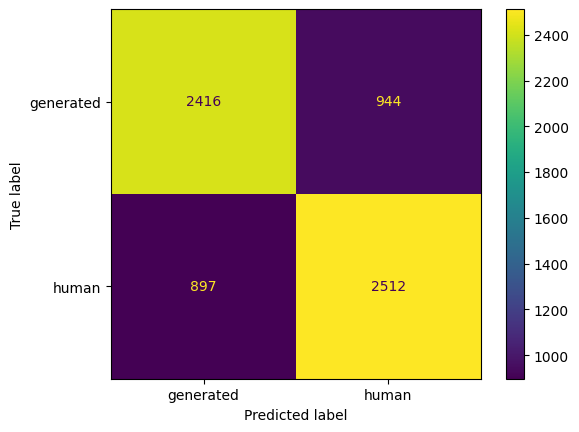

SVC

Best parameters: {'C': 10, 'kernel': 'rbf'}

Best CV score: 0.767297233800682

              precision    recall  f1-score   support



           0       0.79      0.79      0.79      3360

           1       0.79      0.80      0.80      3409



    accuracy                           0.79      6769

   macro avg       0.79      0.79      0.79      6769

weighted avg       0.79      0.79      0.79      6769




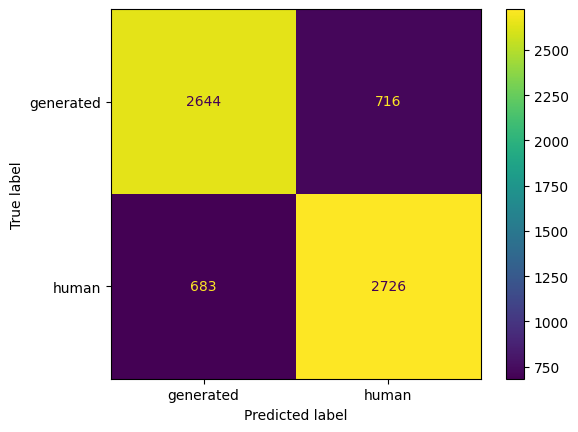

Decision Tree

Best parameters: {'criterion': 'gini', 'max_features': None}

Best CV score: 0.671849456690003

              precision    recall  f1-score   support



           0       0.67      0.66      0.67      3360

           1       0.67      0.69      0.68      3409



    accuracy                           0.67      6769

   macro avg       0.67      0.67      0.67      6769

weighted avg       0.67      0.67      0.67      6769




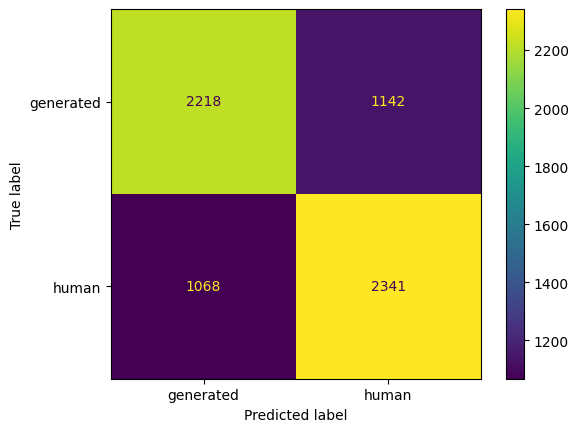

Random Forest

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7518928901200369

              precision    recall  f1-score   support



           0       0.76      0.77      0.77      3360

           1       0.77      0.77      0.77      3409



    accuracy                           0.77      6769

   macro avg       0.77      0.77      0.77      6769

weighted avg       0.77      0.77      0.77      6769




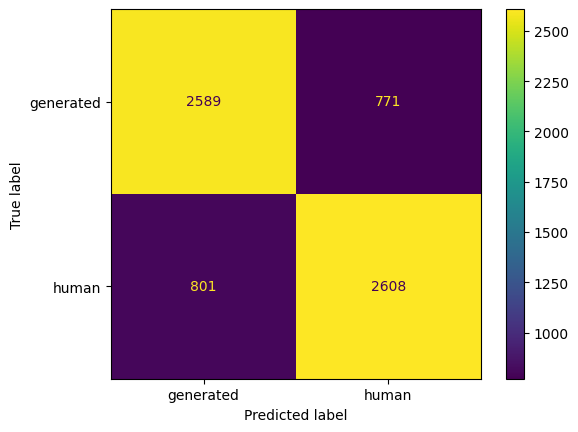

Extra Trees

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7559556786703601

              precision    recall  f1-score   support



           0       0.76      0.76      0.76      3360

           1       0.77      0.76      0.76      3409



    accuracy                           0.76      6769

   macro avg       0.76      0.76      0.76      6769

weighted avg       0.76      0.76      0.76      6769




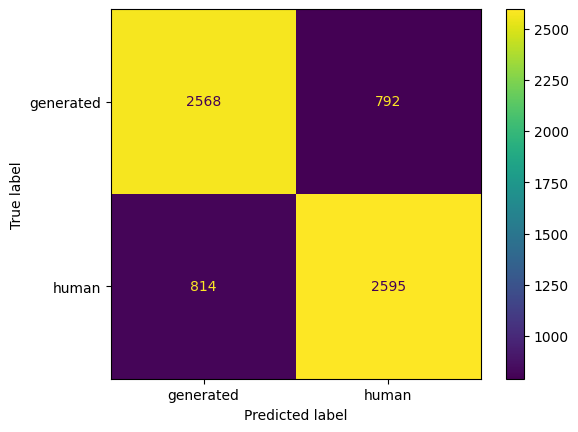

In [27]:
for i in [50,100,200]:
  print("Dimension of embedding: "+str(i))
  x_train, x_test, y_train, y_test=prep_dataset(tokenized_sentences,i)
  models=setup_models()
  train_models(models,x_train,y_train)
  evaluate_models(models,x_test,y_test)

#### Word embedding with trained models

Training Linear Regression

Fitting 5 folds for each of 17 candidates, totalling 85 fits

Found best model

Trained best model

Training SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Found best model

Trained best model

Training Decision Tree

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Found best model

Trained best model

Training Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Training Extra Trees

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Linear Regression

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Best CV score: 0.7445203486169004

              precision    recall  f1-score   support



           0       0.74      0.75      0.74      3360

           1       0.75      0.74      0.75      3409



    accuracy                           0.75      6769

   macro avg       0.75      0.75      0.75   

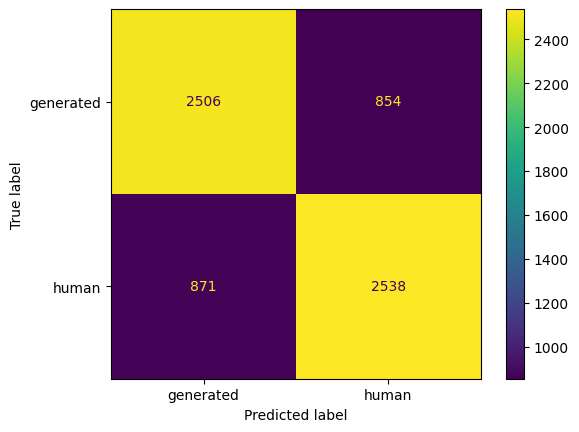

SVC

Best parameters: {'C': 10, 'kernel': 'rbf'}

Best CV score: 0.7951211064797271

              precision    recall  f1-score   support



           0       0.81      0.81      0.81      3360

           1       0.81      0.81      0.81      3409



    accuracy                           0.81      6769

   macro avg       0.81      0.81      0.81      6769

weighted avg       0.81      0.81      0.81      6769




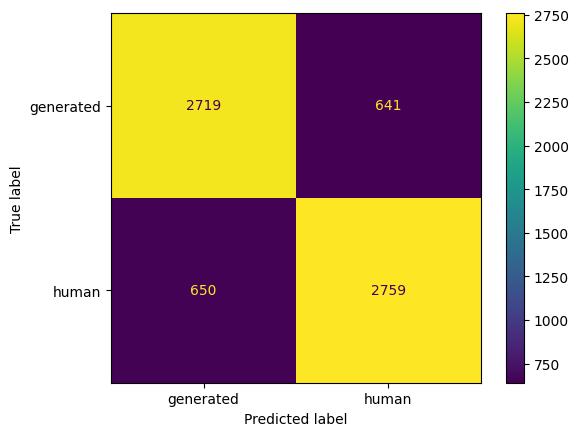

Decision Tree

Best parameters: {'criterion': 'entropy', 'max_features': None}

Best CV score: 0.6546759575608538

              precision    recall  f1-score   support



           0       0.66      0.66      0.66      3360

           1       0.66      0.67      0.66      3409



    accuracy                           0.66      6769

   macro avg       0.66      0.66      0.66      6769

weighted avg       0.66      0.66      0.66      6769




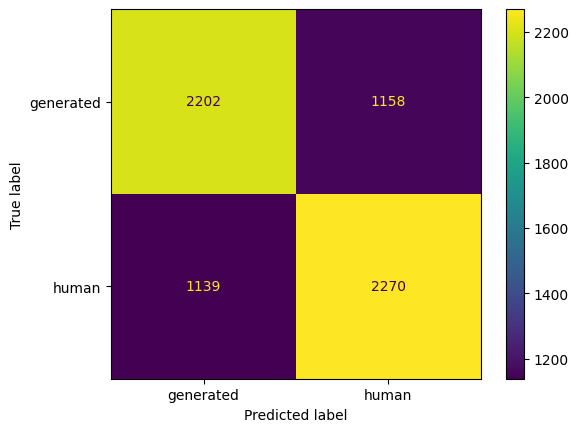

Random Forest

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7525392428439519

              precision    recall  f1-score   support



           0       0.75      0.77      0.76      3360

           1       0.77      0.75      0.76      3409



    accuracy                           0.76      6769

   macro avg       0.76      0.76      0.76      6769

weighted avg       0.76      0.76      0.76      6769




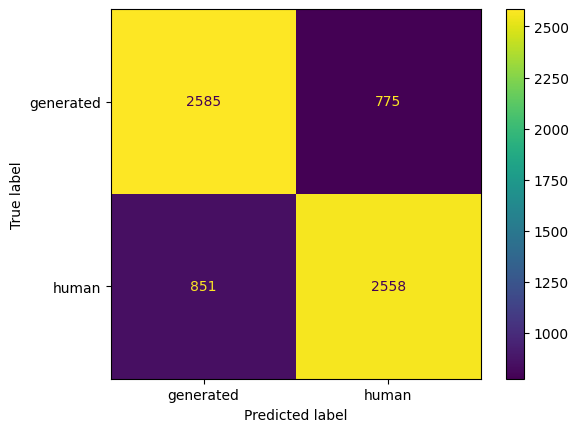

Extra Trees

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.7567867036011081

              precision    recall  f1-score   support



           0       0.75      0.78      0.77      3360

           1       0.77      0.75      0.76      3409



    accuracy                           0.76      6769

   macro avg       0.76      0.76      0.76      6769

weighted avg       0.76      0.76      0.76      6769




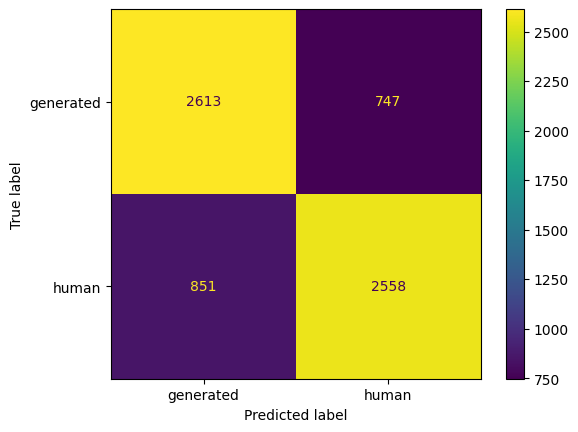

In [ ]:
x_train, x_test, y_train, y_test=prep_dataset("word2vec-google-news-300",300)
models=setup_models()
train_models(models,x_train,y_train)
evaluate_models(models,x_test,y_test)

#### Word embedding with Transformers

Batches:   0%|          | 0/1058 [00:00<?, ?it/s]

Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Linear Regression
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.7361503599848428
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      3360
           1       0.76      0.77      0.76      3409

    accuracy                           0.76      6769
   macro avg       0.76      0.76      0.76      6769
weighted avg       0.76

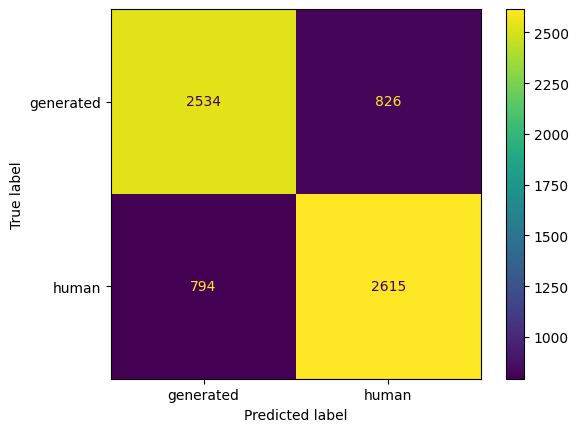

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.7514151572565366
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      3360
           1       0.80      0.80      0.80      3409

    accuracy                           0.80      6769
   macro avg       0.80      0.80      0.80      6769
weighted avg       0.80      0.80      0.80      6769



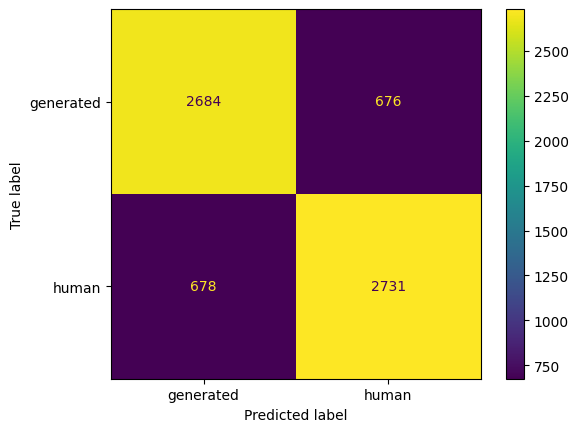

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.6061087902060991
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      3360
           1       0.61      0.62      0.61      3409

    accuracy                           0.61      6769
   macro avg       0.61      0.61      0.61      6769
weighted avg       0.61      0.61      0.61      6769



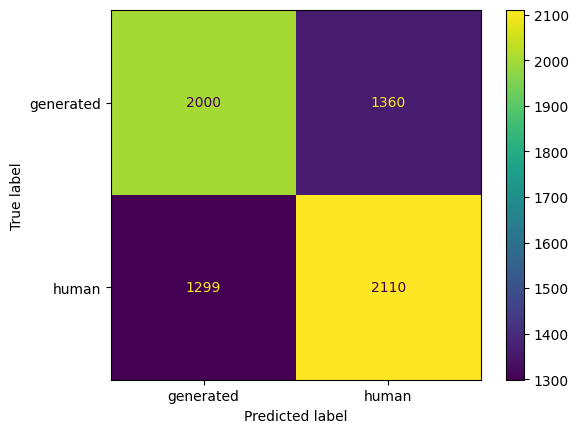

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7077562326869806
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      3360
           1       0.73      0.65      0.69      3409

    accuracy                           0.71      6769
   macro avg       0.71      0.71      0.70      6769
weighted avg       0.71      0.71      0.70      6769



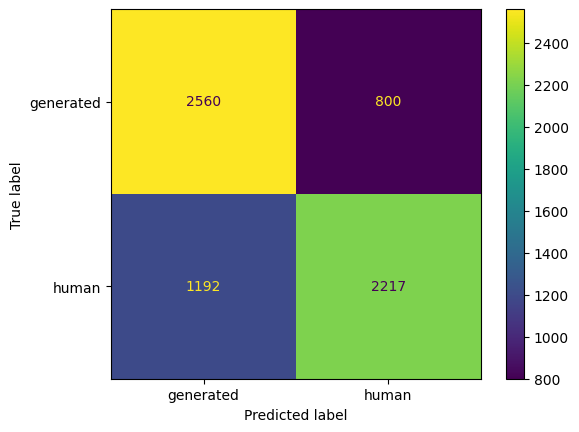

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.6953831948291783
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      3360
           1       0.74      0.65      0.69      3409

    accuracy                           0.71      6769
   macro avg       0.71      0.71      0.70      6769
weighted avg       0.71      0.71      0.70      6769



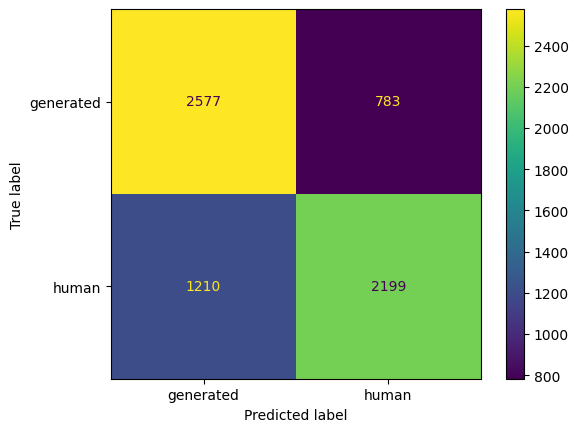

In [26]:
x_train, x_test, y_train, y_test=prep_dataset('all-mpnet-base-v2',tr=True)
models=setup_models()
train_models(models,x_train,y_train)
evaluate_models(models,x_test,y_test)

Batches:   0%|          | 0/1058 [00:00<?, ?it/s]

Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Linear Regression
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.7594181129215611
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      3360
           1       0.77      0.77      0.77      3409

    accuracy                           0.77      6769
   macro avg       0.77      0.77      0.77      6769
weighted avg       0.77     

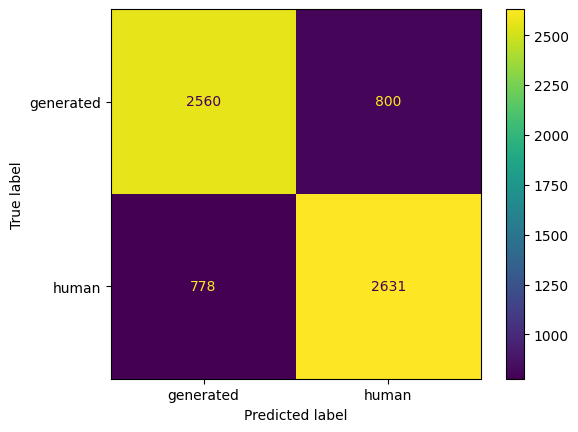

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.7725932550208412
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3360
           1       0.82      0.80      0.81      3409

    accuracy                           0.81      6769
   macro avg       0.81      0.81      0.81      6769
weighted avg       0.81      0.81      0.81      6769



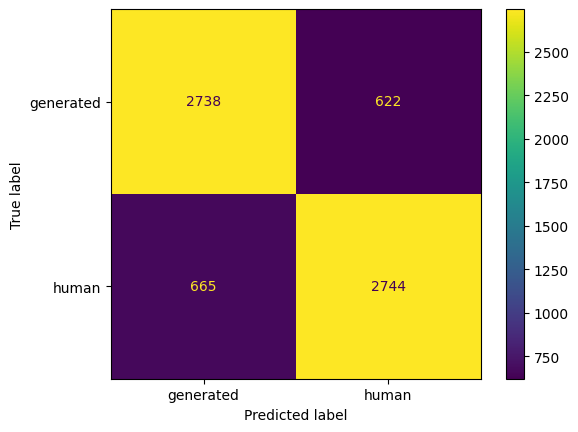

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.6229874480183198
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      3360
           1       0.61      0.61      0.61      3409

    accuracy                           0.61      6769
   macro avg       0.61      0.61      0.61      6769
weighted avg       0.61      0.61      0.61      6769



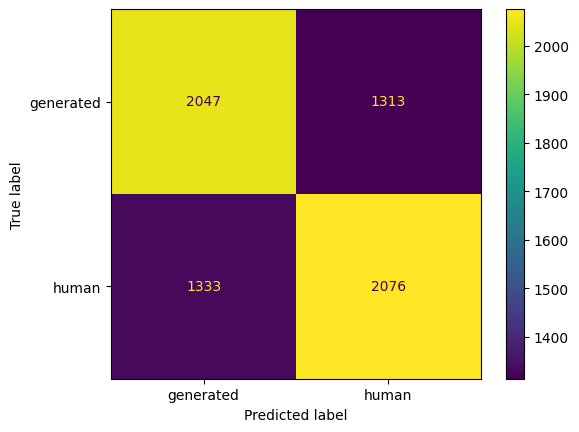

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7123730378578024
              precision    recall  f1-score   support

           0       0.70      0.75      0.73      3360
           1       0.74      0.69      0.71      3409

    accuracy                           0.72      6769
   macro avg       0.72      0.72      0.72      6769
weighted avg       0.72      0.72      0.72      6769



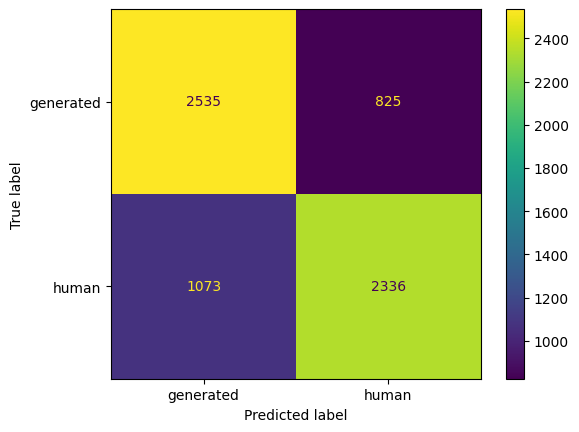

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7185595567867036
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      3360
           1       0.74      0.68      0.71      3409

    accuracy                           0.72      6769
   macro avg       0.72      0.72      0.72      6769
weighted avg       0.72      0.72      0.72      6769



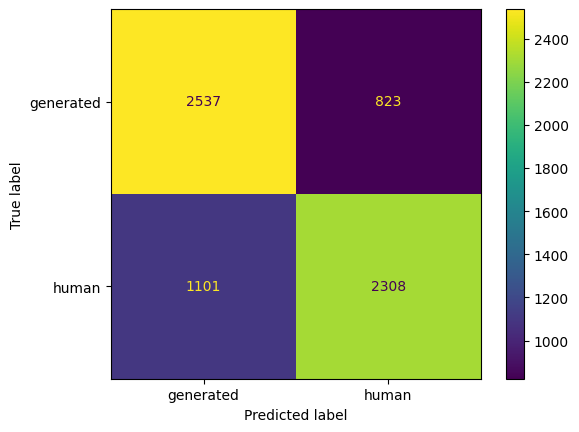

In [27]:
x_train, x_test, y_train, y_test=prep_dataset('multi-qa-mpnet-base-dot-v1',tr=True)
models=setup_models()
train_models(models,x_train,y_train)
evaluate_models(models,x_test,y_test)

### Transformer-based models

In [28]:
# TODO

## Task 2

The challange is subdivided in two main tasks, the second task is a **Multinomial Classification** task that aims at identifying the specific *language model* that generated a given text passage, choosing from 6 different models labeled as A, B, C, D, E and F.

### Data Exploration

In [29]:
# TODO

#### Indexing

In [65]:
df = pd.read_csv("/kaggle/input/subtask2/train.tsv",sep="\t",header=0)
pd.set_option('display.max_colwidth', 150)

df.head()

,id,text,label
0,6239,It was not until many years later that it could be controlled with pesticides. Many pest species have become invasive because they are unpalatable...,A
1,9255,"Users can then pin these images to their profile, creating a public or private board which can be shared with other users. They can also like othe...",F
2,1674,"The best songs are those that I can sing along with, and they’re all there!",B
3,5001,"I found this book to be poorly written. It was written in a very unprofessional manner. The writing is not very well done, it is very poorly writt...",D
4,20779,Regulates the application of the EU tariff quotas for the imports of sugar originating from third countries and the sugar originating from third c...,E


Let's check the dataset size

In [66]:
print(f"No. of sentences: {len(df)}")

No. of sentences: 22416


Let's print some sentences and try to understand something about this dataset

In [67]:
for i in range(20):
    print(df['text'][i])
    print("\n")

It was not until many years later that it could be controlled with pesticides. Many pest species have become invasive because they are unpalatable to humans or animals, often causing damage from their toxic substances (which can also harm plants). Examples include the Asian elephant’s hairy snake droppings, which poisoned European ivory owls for hundreds of years, and more recently rabid dogs killing wild cats by biting them off at night. The spread of invasive species is affected both by natural
Users can then pin these images to their profile, creating a public or private board which can be shared with other users. They can also like other users pins, creating an online community of users who can share and comment on each others content. The site also allows users to follow other users, creating an online network of people who are interested in the same things. This can help users to discover new content and ideas, as well as staying upto
The best songs are those that I can sing alon


Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents.

In the following cell, we index the dataframe's documents.


In [ ]:

import pyterrier as pt
if not pt.started():
  pt.init()
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
df['docno']=str(df["id"])
index_ref = indexer.index(df["text"], df["docno"])
index = pt.IndexFactory.of(index_ref)

Some statistics about our data

In [ ]:

print(index.getCollectionStatistics().toString())

Now we will ask some queries

In [ ]:
query = "potato"
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query)
br = pt.BatchRetrieve(index, wmodel="TF_IDF")
queries=br.search(query)
queries.head()

#### Clustering

In [73]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
documents=np.array(df['text'])
labels = np.array(df['label'])

We have obtained a relative small vocubalary only 11k words

In [74]:

vectorizer.fit(documents)
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

vector_documents = vectorizer.transform(documents)

Length of vocabulary: 10210


we try to see if clustering this data can lead to actual classes

In [75]:
for i in range(1,200):
    if (labels[i] == labels[1]):
      print('Similarity:', vector_documents[1].multiply(vector_documents[i]).sum())

Similarity: 1.0000000000000002
Similarity: 0.0
Similarity: 0.0
Similarity: 0.012156606185854915
Similarity: 0.021497454396714348
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.008450299243712817
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.01683459219337702
Similarity: 0.0
Similarity: 0.0035152820429519157
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.10561271796235441
Similarity: 0.005680273800866435
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.004780727160835253
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.04324886923082573
Similarity: 0.010809344661050681
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.010659129443019904
Similarity: 0.016782537955139464
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.015559273374705343
Similarity: 0.0
Similarity: 0.03265266747675147


We have used the most basic clustering algorithm to see if there is any chance

In [76]:
k = len(set(labels))
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 42639.255535675584.
Iteration 1, inertia 21981.855065696767.
Iteration 2, inertia 21891.642122140645.
Iteration 3, inertia 21871.450558083987.
Iteration 4, inertia 21861.98554741546.
Iteration 5, inertia 21855.538449646432.
Iteration 6, inertia 21850.294028994867.
Iteration 7, inertia 21845.636569516482.
Iteration 8, inertia 21841.60276011332.
Iteration 9, inertia 21838.876690265442.
Iteration 10, inertia 21837.093220729595.
Iteration 11, inertia 21835.443157732654.
Iteration 12, inertia 21833.845821496292.
Iteration 13, inertia 21832.692040164104.
Iteration 14, inertia 21831.015931054746.
Iteration 15, inertia 21828.599164056563.
Iteration 16, inertia 21825.83792886217.
Iteration 17, inertia 21823.460775646938.
Iteration 18, inertia 21821.445512622464.
Iteration 19, inertia 21819.758405872468.
Iteration 20, inertia 21818.39143257262.
Iteration 21, inertia 21817.326594983544.
Iteration 22, inertia 21816.531765654043.
Iteration 23, inertia 21

KMeans(max_iter=100, n_clusters=6, n_init=2, random_state=2307, verbose=True)


Evaluation of our clustering

In [77]:
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(labels, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(labels, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(labels, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(labels, kmeans.labels_)))


Intrinsic evaluation measures:
Within-cluster sum-of-squares: 21813.83683564433
Silhouette coefficient: 0.002723720495581728
Extrinsic evaluation measures:
Homogeneity: 0.010636702286770043
Completeness: 0.014192253102007073
V-measure: 0.012159897076682689
Adjusted Rand-Index: 0.0026782561394675633


As we can see from this metrics and as we expect it perfomed terribly. We can say that the content of the sentences is not related to the label.

### Bag of Words-based models and other approaches

In [30]:
# TODO

### Text embedding approaches

In [31]:
df = pd.read_csv("/kaggle/input/subtask2/train.tsv",sep="\t",header=0)
pd.set_option('display.max_colwidth', 150)
labels = ["generated", "human"]
df = df.drop("id", axis=1)
df.head()

,text,label
0,It was not until many years later that it could be controlled with pesticides. Many pest species have become invasive because they are unpalatable...,A
1,"Users can then pin these images to their profile, creating a public or private board which can be shared with other users. They can also like othe...",F
2,"The best songs are those that I can sing along with, and they’re all there!",B
3,"I found this book to be poorly written. It was written in a very unprofessional manner. The writing is not very well done, it is very poorly writt...",D
4,Regulates the application of the EU tariff quotas for the imports of sugar originating from third countries and the sugar originating from third c...,E


In [33]:
df.sample(frac=1)
df['label'] = df['label'].replace({'A':0, 'B':1,'C':2,'D':3,'E':4,'F':5})
labels=['A','B','C','D','E','F']

In [34]:
docs = [re.sub('\n', ' ', doc) for doc in df.text]
sentences = [re.split('[?!.]\s', doc) for doc in docs]
sentences = list(flatten(sentences))
sentences[:3]

['you need to stop the engine and wait until it stops',
 'This is how I would do it: // Check if its safe',
 'The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessary or appropriate']

In [35]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]

#### Building our embedding

Dimesnion of embedding: 50
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Linear Regression
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.35043606812483785
              precision    recall  f1-score   support

           0       0.45      0.56      0.50       712
           1       0.33      0.24      0.28       730
           2       0.32      0.22      0.26       737
           3       0.41      0.39      0.40       774
           4       0.30      0.21      0.25       765
           5       0.36      0.60      0.45       766

    

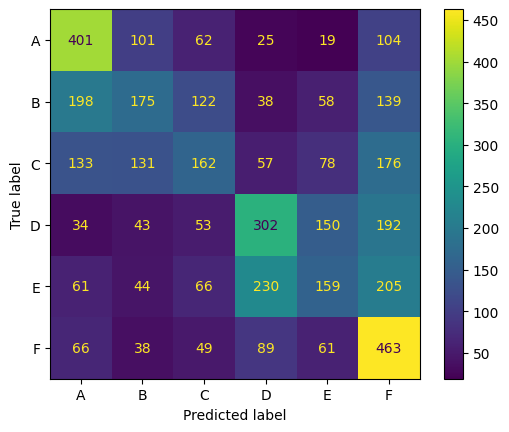

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.39747263767614766
              precision    recall  f1-score   support

           0       0.54      0.57      0.55       712
           1       0.34      0.31      0.32       730
           2       0.34      0.31      0.33       737
           3       0.42      0.39      0.40       774
           4       0.34      0.30      0.32       765
           5       0.50      0.67      0.58       766

    accuracy                           0.42      4484
   macro avg       0.41      0.42      0.42      4484
weighted avg       0.41      0.42      0.42      4484



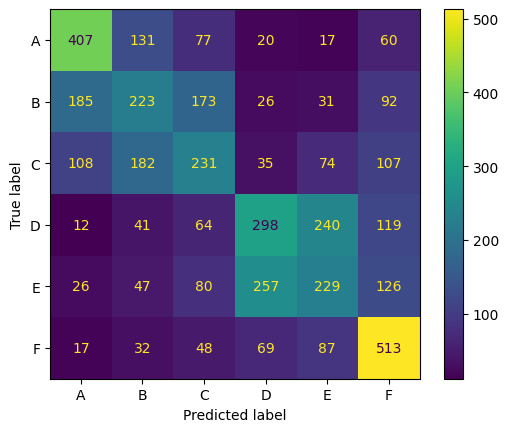

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.26070679411663644
              precision    recall  f1-score   support

           0       0.33      0.32      0.33       712
           1       0.19      0.20      0.19       730
           2       0.22      0.21      0.21       737
           3       0.27      0.27      0.27       774
           4       0.24      0.23      0.24       765
           5       0.33      0.33      0.33       766

    accuracy                           0.26      4484
   macro avg       0.26      0.26      0.26      4484
weighted avg       0.26      0.26      0.26      4484



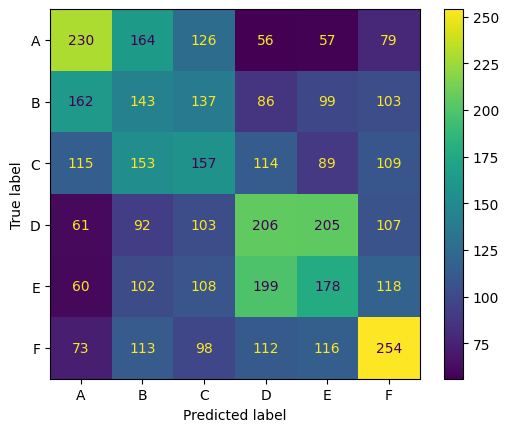

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.33937943133167137
              precision    recall  f1-score   support

           0       0.42      0.53      0.47       712
           1       0.26      0.21      0.23       730
           2       0.26      0.21      0.23       737
           3       0.38      0.33      0.35       774
           4       0.30      0.28      0.29       765
           5       0.43      0.58      0.50       766

    accuracy                           0.36      4484
   macro avg       0.34      0.36      0.35      4484
weighted avg       0.34      0.36      0.35      4484



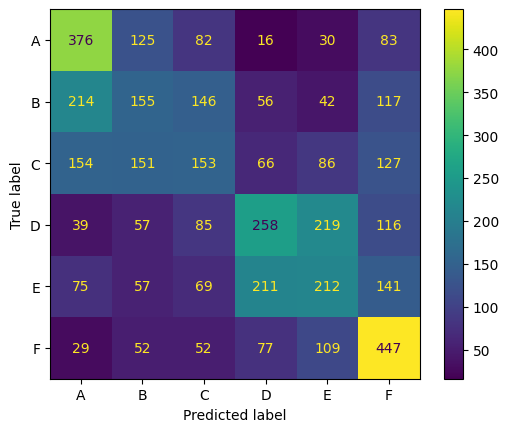

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.33101035577002513
              precision    recall  f1-score   support

           0       0.43      0.54      0.48       712
           1       0.27      0.22      0.24       730
           2       0.24      0.18      0.21       737
           3       0.36      0.34      0.35       774
           4       0.29      0.24      0.27       765
           5       0.44      0.60      0.51       766

    accuracy                           0.36      4484
   macro avg       0.34      0.36      0.34      4484
weighted avg       0.34      0.36      0.34      4484



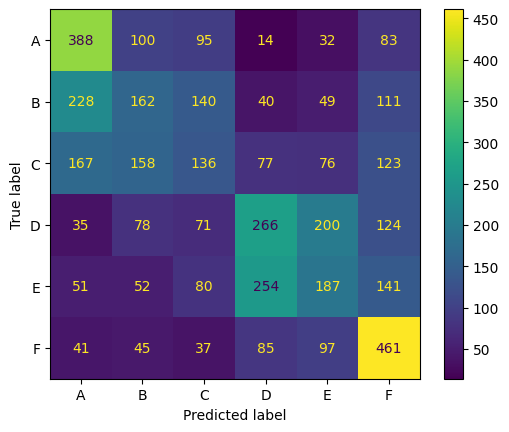

Dimesnion of embedding: 100
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Found best model


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Linear Regression
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.3883629290222183
              precision    recall  f1-score   support

           0       0.49      0.58      0.53       712
           1       0.34      0.28      0.31       730
           2       0.31      0.25      0.28       737
           3       0.41      0.38      0.39       774
           4       0.33      0.25      0.29       765
           5       0.43      0.65      0.51       766

    accuracy          

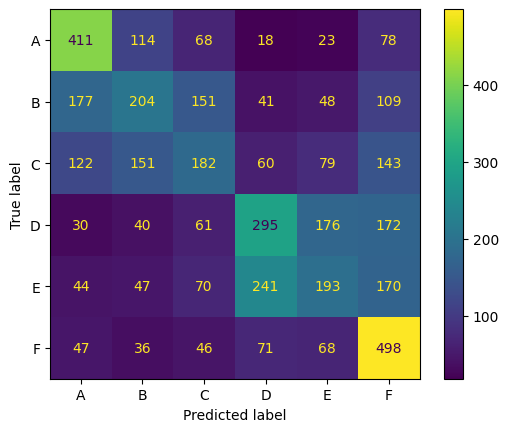

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.40936854845681686
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       712
           1       0.37      0.33      0.34       730
           2       0.36      0.36      0.36       737
           3       0.45      0.39      0.42       774
           4       0.38      0.35      0.36       765
           5       0.54      0.68      0.60       766

    accuracy                           0.45      4484
   macro avg       0.44      0.45      0.45      4484
weighted avg       0.44      0.45      0.45      4484



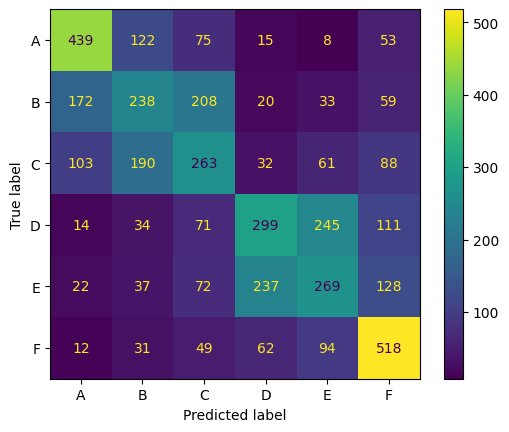

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.26929599994775705
              precision    recall  f1-score   support

           0       0.35      0.34      0.35       712
           1       0.23      0.25      0.24       730
           2       0.22      0.23      0.22       737
           3       0.28      0.27      0.28       774
           4       0.25      0.23      0.24       765
           5       0.35      0.35      0.35       766

    accuracy                           0.28      4484
   macro avg       0.28      0.28      0.28      4484
weighted avg       0.28      0.28      0.28      4484



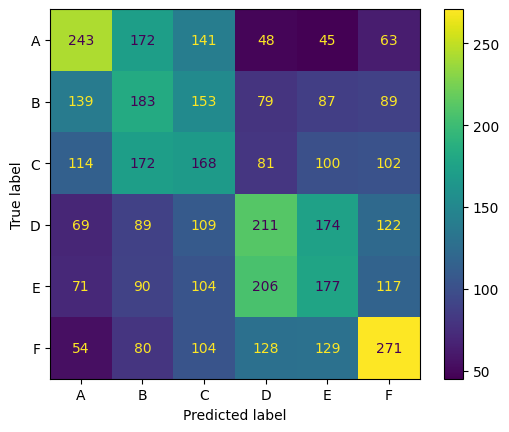

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.35541109637037793
              precision    recall  f1-score   support

           0       0.46      0.55      0.50       712
           1       0.28      0.25      0.26       730
           2       0.27      0.22      0.24       737
           3       0.38      0.35      0.36       774
           4       0.32      0.26      0.29       765
           5       0.46      0.61      0.52       766

    accuracy                           0.37      4484
   macro avg       0.36      0.37      0.36      4484
weighted avg       0.36      0.37      0.36      4484



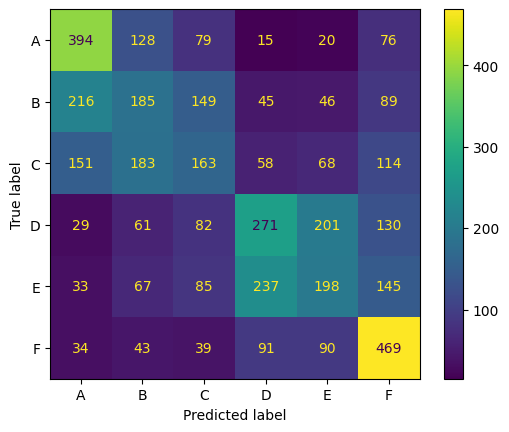

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.3594511587674155
              precision    recall  f1-score   support

           0       0.45      0.57      0.50       712
           1       0.30      0.26      0.28       730
           2       0.28      0.22      0.24       737
           3       0.40      0.38      0.39       774
           4       0.32      0.24      0.27       765
           5       0.46      0.63      0.53       766

    accuracy                           0.38      4484
   macro avg       0.37      0.38      0.37      4484
weighted avg       0.37      0.38      0.37      4484



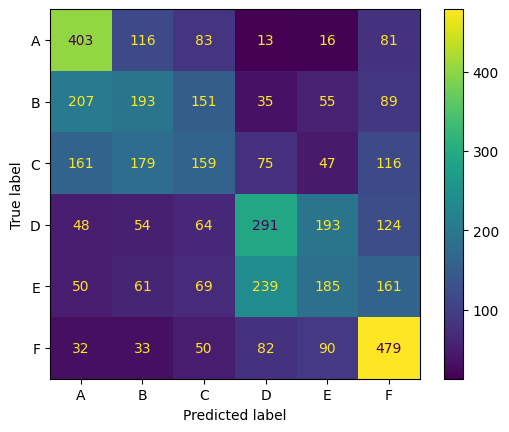

Dimesnion of embedding: 200
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Found best model


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Linear Regression
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.389292988674678
              precision    recall  f1-score   support

           0       0.53      0.61      0.57       712
           1       0.38      0.30      0.33       730
           2       0.36      0.30      0.32       737
           3       0.41      0.39      0.40       774
           4       0.33      0.26      0.29       765
           5       0.44      0.67      0.53       766

    accuracy           

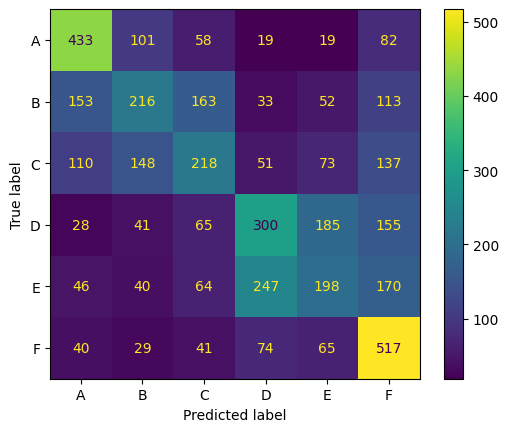

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.41085536439872045
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       712
           1       0.36      0.32      0.34       730
           2       0.37      0.38      0.37       737
           3       0.47      0.41      0.44       774
           4       0.39      0.34      0.36       765
           5       0.54      0.69      0.61       766

    accuracy                           0.46      4484
   macro avg       0.45      0.46      0.46      4484
weighted avg       0.45      0.46      0.46      4484



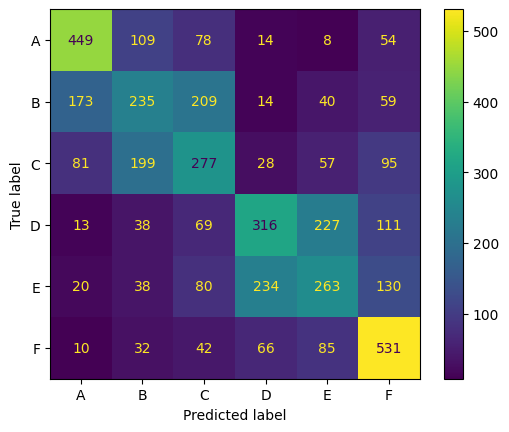

Decision Tree
Best parameters: {'criterion': 'entropy', 'max_features': None}
Best CV score: 0.2750388207026956
              precision    recall  f1-score   support

           0       0.36      0.35      0.35       712
           1       0.22      0.23      0.23       730
           2       0.20      0.21      0.20       737
           3       0.28      0.29      0.29       774
           4       0.24      0.22      0.23       765
           5       0.35      0.34      0.35       766

    accuracy                           0.27      4484
   macro avg       0.28      0.27      0.27      4484
weighted avg       0.28      0.27      0.27      4484



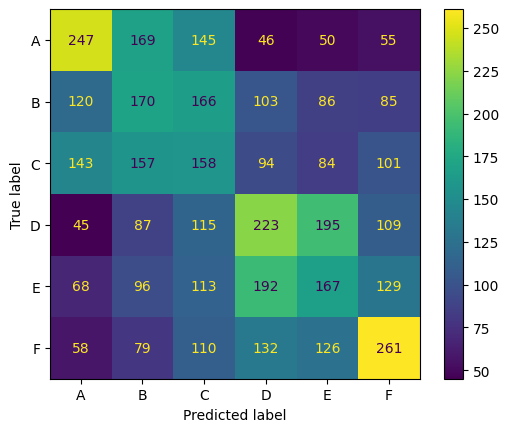

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.36461203524169133
              precision    recall  f1-score   support

           0       0.49      0.58      0.53       712
           1       0.28      0.26      0.27       730
           2       0.27      0.21      0.24       737
           3       0.40      0.39      0.40       774
           4       0.34      0.28      0.31       765
           5       0.48      0.63      0.54       766

    accuracy                           0.39      4484
   macro avg       0.38      0.39      0.38      4484
weighted avg       0.38      0.39      0.38      4484



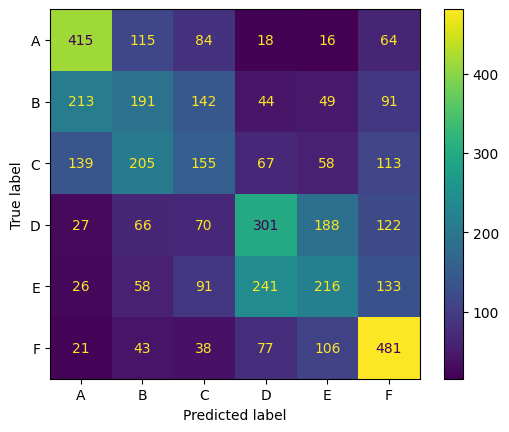

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.37130649871949994
              precision    recall  f1-score   support

           0       0.44      0.57      0.50       712
           1       0.28      0.24      0.26       730
           2       0.30      0.23      0.26       737
           3       0.40      0.38      0.39       774
           4       0.33      0.26      0.29       765
           5       0.47      0.62      0.53       766

    accuracy                           0.38      4484
   macro avg       0.37      0.38      0.37      4484
weighted avg       0.37      0.38      0.37      4484



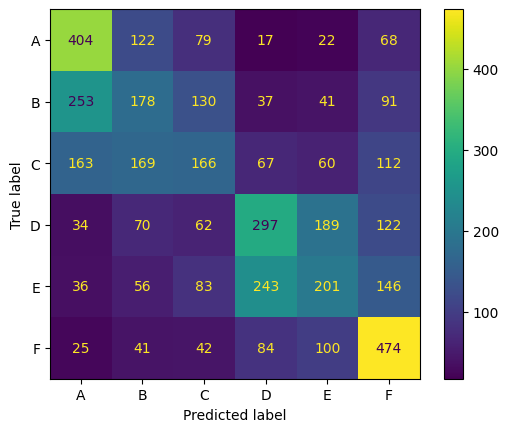

In [36]:
for i in [50,100,200]:
    print("Dimension of embedding: "+str(i))
    x_train, x_test, y_train, y_test=prep_dataset(tokenized_sentences,i)
    models=setup_models()
    train_models(models,x_train,y_train)
    evaluate_models(models,x_test,y_test)

#### Embeddin with pretrained models

Training Linear Regression

Fitting 5 folds for each of 17 candidates, totalling 85 fits

Found best model

Trained best model

Training SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Found best model

Trained best model

Training Decision Tree

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Found best model

Trained best model

Training Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Training Extra Trees

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Linear Regression

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Best CV score: 0.34411567389988756

              precision    recall  f1-score   support



           0       0.43      0.53      0.48       712

           1       0.30      0.20      0.24       730

           2       0.25      0.17      0.20       737

           3       0.37      0.36      0.36     

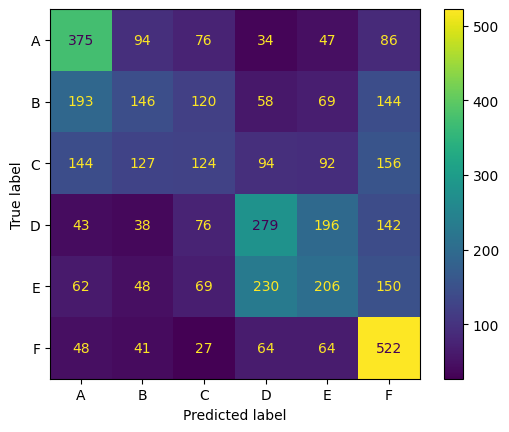

SVC

Best parameters: {'C': 10, 'kernel': 'rbf'}

Best CV score: 0.38073778853635337

              precision    recall  f1-score   support



           0       0.53      0.52      0.53       712

           1       0.34      0.32      0.33       730

           2       0.33      0.33      0.33       737

           3       0.42      0.40      0.41       774

           4       0.40      0.36      0.38       765

           5       0.56      0.66      0.61       766



    accuracy                           0.43      4484

   macro avg       0.43      0.43      0.43      4484

weighted avg       0.43      0.43      0.43      4484




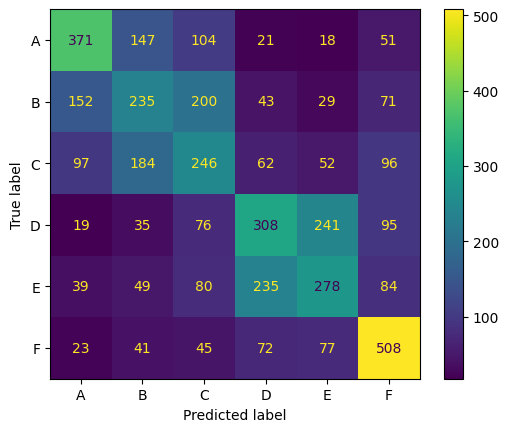

Decision Tree

Best parameters: {'criterion': 'entropy', 'max_features': None}

Best CV score: 0.23895863338687712

              precision    recall  f1-score   support



           0       0.25      0.26      0.25       712

           1       0.20      0.20      0.20       730

           2       0.19      0.20      0.19       737

           3       0.25      0.24      0.24       774

           4       0.21      0.21      0.21       765

           5       0.31      0.29      0.30       766



    accuracy                           0.23      4484

   macro avg       0.23      0.23      0.23      4484

weighted avg       0.23      0.23      0.23      4484




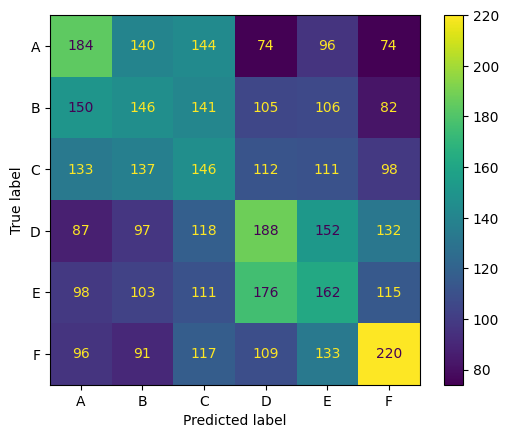

Random Forest

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.3319834385432916

              precision    recall  f1-score   support



           0       0.40      0.42      0.41       712

           1       0.26      0.22      0.24       730

           2       0.25      0.18      0.21       737

           3       0.33      0.35      0.34       774

           4       0.34      0.29      0.31       765

           5       0.45      0.65      0.53       766



    accuracy                           0.35      4484

   macro avg       0.34      0.35      0.34      4484

weighted avg       0.34      0.35      0.34      4484




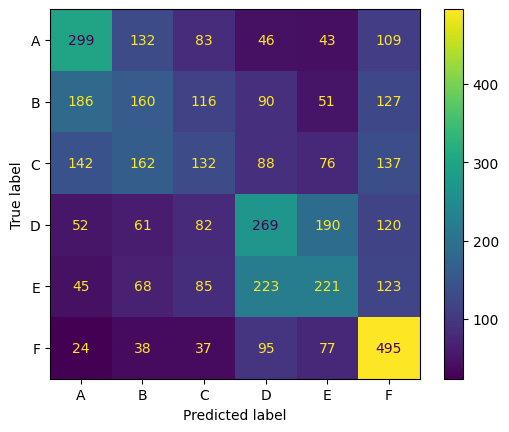

Extra Trees

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.32640784530977407

              precision    recall  f1-score   support



           0       0.36      0.41      0.38       712

           1       0.25      0.22      0.23       730

           2       0.27      0.18      0.22       737

           3       0.34      0.32      0.33       774

           4       0.31      0.27      0.29       765

           5       0.43      0.64      0.52       766



    accuracy                           0.34      4484

   macro avg       0.33      0.34      0.33      4484

weighted avg       0.33      0.34      0.33      4484




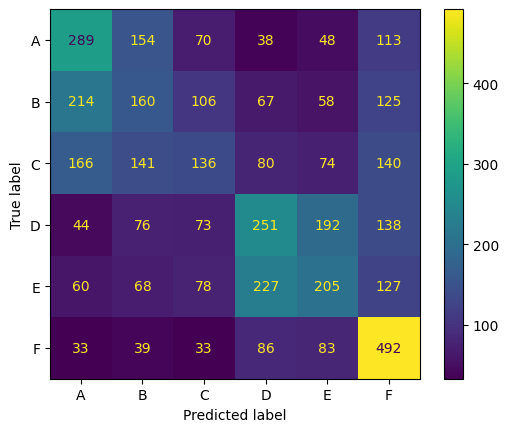

In [ ]:
x_train, x_test, y_train, y_test=prep_dataset("word2vec-google-news-300",300)
models=setup_models()
train_models(models,x_train,y_train)
evaluate_models(models,x_test,y_test)

####Embedding with transformers

Training Linear Regression

Fitting 5 folds for each of 17 candidates, totalling 85 fits

Found best model

Trained best model

Training SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Found best model

Trained best model

Training Decision Tree

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Found best model

Trained best model

Training Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Training Extra Trees

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Found best model

Trained best model

Linear Regression

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Best CV score: 0.24967701218985044

              precision    recall  f1-score   support



           0       0.31      0.35      0.33       712

           1       0.19      0.15      0.17       730

           2       0.21      0.17      0.19       737

           3       0.30      0.30      0.30      

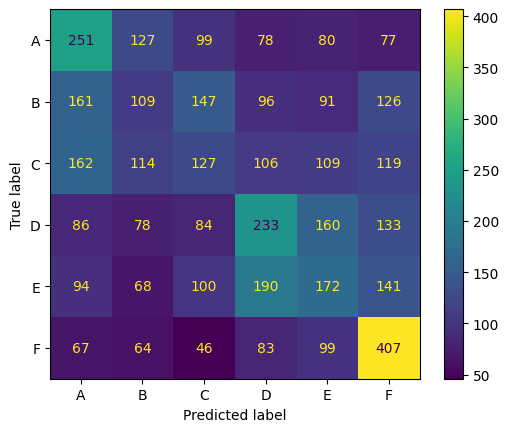

SVC

Best parameters: {'C': 10, 'kernel': 'rbf'}

Best CV score: 0.26175672170830816

              precision    recall  f1-score   support



           0       0.29      0.31      0.30       712

           1       0.23      0.24      0.23       730

           2       0.22      0.20      0.21       737

           3       0.30      0.31      0.31       774

           4       0.26      0.24      0.25       765

           5       0.51      0.50      0.50       766



    accuracy                           0.30      4484

   macro avg       0.30      0.30      0.30      4484

weighted avg       0.30      0.30      0.30      4484




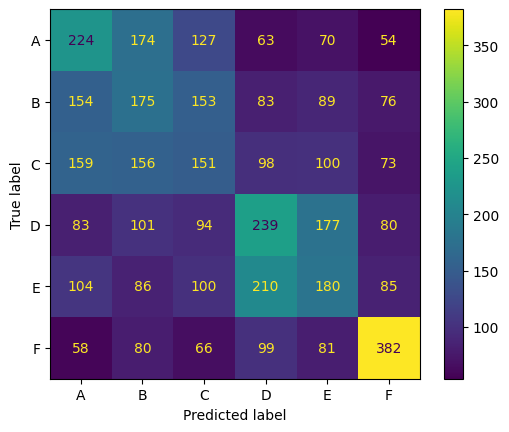

Decision Tree

Best parameters: {'criterion': 'entropy', 'max_features': None}

Best CV score: 0.18441877629930606

              precision    recall  f1-score   support



           0       0.19      0.19      0.19       712

           1       0.19      0.18      0.19       730

           2       0.20      0.19      0.20       737

           3       0.19      0.20      0.19       774

           4       0.18      0.18      0.18       765

           5       0.22      0.23      0.23       766



    accuracy                           0.20      4484

   macro avg       0.20      0.20      0.20      4484

weighted avg       0.20      0.20      0.20      4484




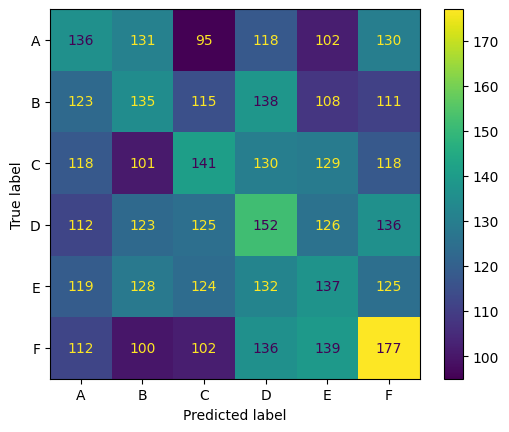

Random Forest

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.19799347844046283

              precision    recall  f1-score   support



           0       0.21      0.21      0.21       712

           1       0.20      0.19      0.20       730

           2       0.18      0.17      0.17       737

           3       0.20      0.22      0.21       774

           4       0.20      0.20      0.20       765

           5       0.29      0.27      0.28       766



    accuracy                           0.21      4484

   macro avg       0.21      0.21      0.21      4484

weighted avg       0.21      0.21      0.21      4484




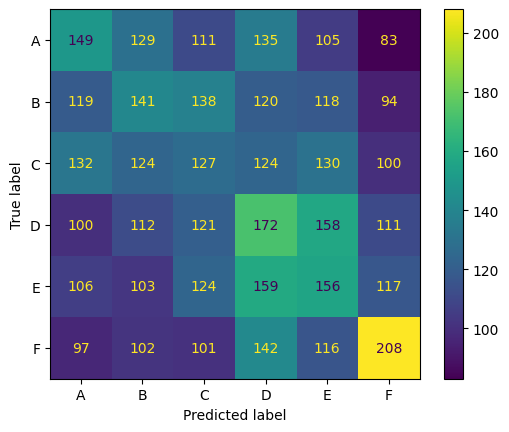

Extra Trees

Best parameters: {'criterion': 'entropy'}

Best CV score: 0.20538140432211258

              precision    recall  f1-score   support



           0       0.17      0.16      0.16       712

           1       0.17      0.17      0.17       730

           2       0.20      0.19      0.20       737

           3       0.22      0.25      0.24       774

           4       0.19      0.19      0.19       765

           5       0.32      0.32      0.32       766



    accuracy                           0.21      4484

   macro avg       0.21      0.21      0.21      4484

weighted avg       0.21      0.21      0.21      4484




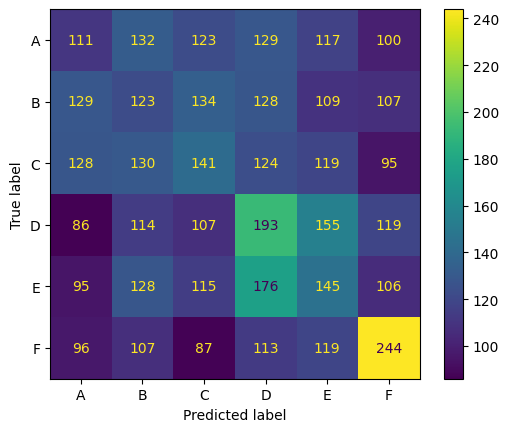

In [ ]:
x_train, x_test, y_train, y_test=prep_dataset('all-mpnet-base-v2',tr=True)
models=setup_models()
train_models(models,x_train,y_train)
evaluate_models(models,x_test,y_test)

Batches:   0%|          | 0/701 [00:00<?, ?it/s]

Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Linear Regression
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.2855578801763638
              precision    recall  f1-score   support

           0       0.36      0.42      0.39       712
           1       0.22      0.16      0.18       730
           2       0.21      0.16      0.18       737
           3       0.36      0.36      0.36       774
           4       0.30  

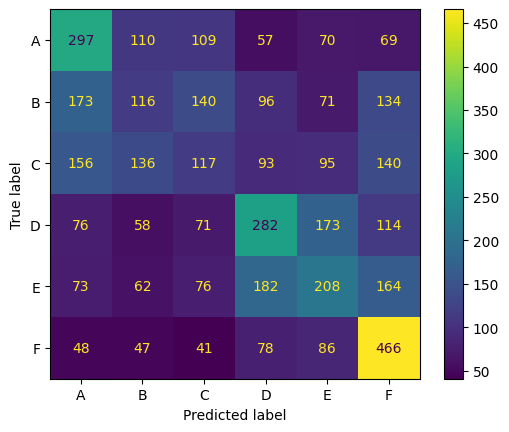

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.27086556583383764
              precision    recall  f1-score   support

           0       0.37      0.37      0.37       712
           1       0.25      0.25      0.25       730
           2       0.24      0.24      0.24       737
           3       0.33      0.32      0.33       774
           4       0.28      0.27      0.28       765
           5       0.53      0.56      0.55       766

    accuracy                           0.34      4484
   macro avg       0.33      0.34      0.33      4484
weighted avg       0.33      0.34      0.34      4484



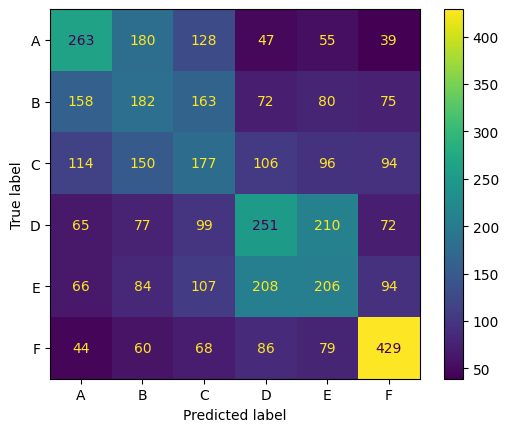

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.18837860458795636
              precision    recall  f1-score   support

           0       0.19      0.19      0.19       712
           1       0.18      0.16      0.17       730
           2       0.15      0.15      0.15       737
           3       0.20      0.20      0.20       774
           4       0.18      0.18      0.18       765
           5       0.22      0.24      0.23       766

    accuracy                           0.19      4484
   macro avg       0.19      0.19      0.19      4484
weighted avg       0.19      0.19      0.19      4484



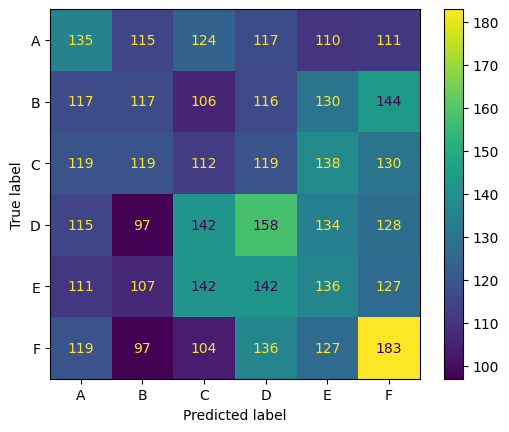

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.21513983448262453
              precision    recall  f1-score   support

           0       0.23      0.23      0.23       712
           1       0.19      0.19      0.19       730
           2       0.19      0.17      0.18       737
           3       0.21      0.23      0.22       774
           4       0.23      0.22      0.22       765
           5       0.32      0.33      0.33       766

    accuracy                           0.23      4484
   macro avg       0.23      0.23      0.23      4484
weighted avg       0.23      0.23      0.23      4484



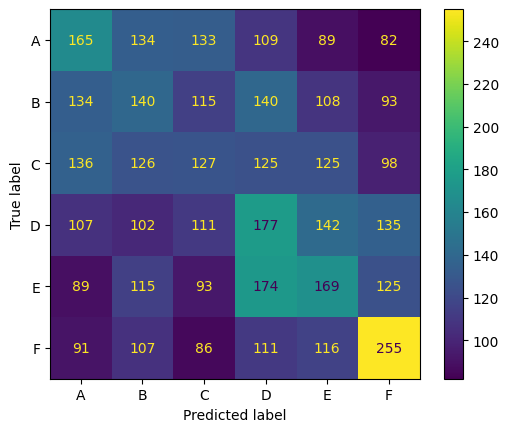

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.216258218768679
              precision    recall  f1-score   support

           0       0.20      0.19      0.20       712
           1       0.19      0.18      0.18       730
           2       0.17      0.17      0.17       737
           3       0.24      0.26      0.25       774
           4       0.22      0.22      0.22       765
           5       0.31      0.33      0.32       766

    accuracy                           0.23      4484
   macro avg       0.22      0.22      0.22      4484
weighted avg       0.22      0.23      0.22      4484



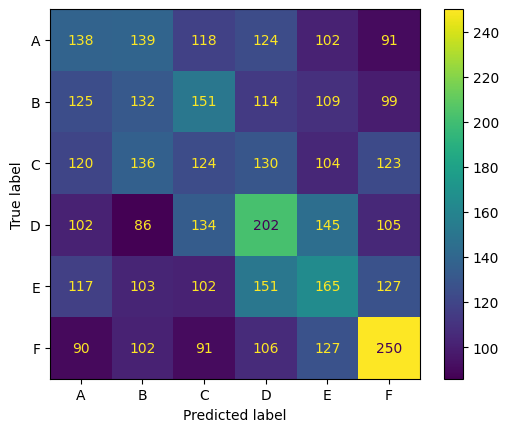

In [37]:
x_train, x_test, y_train, y_test=prep_dataset('multi-qa-mpnet-base-dot-v1',tr=True)
models=setup_models()
train_models(models,x_train,y_train)
evaluate_models(models,x_test,y_test)

### Transformer-based models

In [ ]:
# TODO

## Conclusions

In [ ]:
# TODO